# 인스타 카트 데이터
- 데이터 : https://www.kaggle.com/competitions/instacart-market-basket-analysis

- 주제: 상품 추천 시스템 구축 (협업 필터링 기반)
  목표: 고객 구매 이력으로 유사 고객 또는 상품 추천 시스템 개발
- --세부 주제
- (1) 고객-상품 매트릭스 생성 및 협업 필터링 적용
- (2) 카테고리별 Top N 추천 리스트 자동 생성 => 과거 구매 이력을 기반으로 유사 상품/고객을 찾아 재구매 가능성 높은 상품 추천
- (3) 신규 고객을 위한 cold-start 문제 대응 방안 (인기 상품 추천 or 콘텐츠 기반)
- (4) 사용자 행동 기반 Matrix Factorization 추천


각각 모델을 만든 후, 종합( 앙상블 ) 하기
예)
    - 최종 추천 리스트 = 
    40% * 협업 필터링 추천 +
    30% * 클러스터별 인기 상품 +
    30% * 재구매율 높은 상품

혹은

    - 기존 고객: 협업 필터링 or SVD 기반 추천
    - 신규 고객: KMeans 군집별 추천 or 인기 상품
    - 신규 상품 포함: 콘텐츠 기반 유사 상품 추천


### 데이터 불러오기

* aisles.csv : 상품 분류(카테고리)
    - aisle_id: 고유한 진열대 번호 또는 카테고리 ID
    - aisle: 해당 ID에 대응하는 상품 분류명 (예: prepared soups salads, dry pasta, beauty 등)
    - 장바구니 분석 (Market Basket Analysis) → 어떤 진열대(aisle) 상품이 같이 구매되는지 분
    - 추천 시스템 → 고객이 자주 구매하는 aisle을 기반으로 다른 관련 제품 추천



* order_products__prior : 고객의 과거 주문 이력
    - order_id :	주문 번호 (하나의 장바구니를 의미)
    - product_id :	해당 주문에 담긴 상품의 ID
    - add_to_cart_order	: 장바구니에 담긴 순서 (1이면 가장 먼저 담은 상품)
    - reordered	: 이전에 한 번이라도 주문했던 상품인지 여부 (1: 재구매, 0: 최초 구매)

* orders : 고객의 구매 시점 및 순서를 파악하는 핵심 데이터

    - order_id : 주문 고유 번호 (이걸로 다른 테이블과 연결됨)
    - user_id : 고객 ID (추천 시스템에서 매우 중요!)
    - eval_set :이 주문이 어떤 용도인지: 'prior', 'train', 'test'
    - order_number	해당 고객의 몇 번째 주문인지 (1부터 시작)
    - order_dow	요일 정보 (0=일요일, 6=토요일)
    - order_hour_of_day	주문 시간 (0~23시)
    - days_since_prior_order	이전 주문 이후 경과일 (첫 주문은 NaN)]
* products : 상품의 메타 정보를 담고 있는 테이블
    - product_id	상품 고유 ID (추천 시스템의 핵심 키값)
    - product_name	상품 이름 (설명, UI 출력 등에 활용)
    - aisle_id	진열대(소분류) ID → aisles.csv로 매핑 가능
    - department_id	부서(대분류) ID → departments.csv로 매핑 가능


* order_products__train : 추천 시스템 모델을 훈련하고 나서 성능을 평가할 때 쓰는 "정답(label)" 역할의 데이터셋  (모델 평가용 !!)

* departments :

* food_business_seoul_20221231 : 서울시 내 음식점 및 유흥업소 등의 상가 정보   (왜있는지 모르겠음..)



In [77]:
import pandas as pd
import numpy as np

#### aisles.csv : 상품 분류(카테고리) 

In [93]:
# (1) aisles.csv : 상품 분류(카테고리) 

aisles = pd.read_csv('/Users/jeonseoyeong/Desktop/패스트캠퍼스 20기(파이썬)/팀플/aisles.csv')
aisles.isna().sum()

# 다 유니크한 값으로 되어있어 split을 통해 큰 카테고리로 분류를 해야할 듯..?

aisle_id    0
aisle       0
dtype: int64

In [28]:
aisle['aisle'].value_counts()   

1

#### order_products__prior
- order_id :	주문 번호 (하나의 장바구니를 의미)
- product_id :	해당 주문에 담긴 상품의 ID
- add_to_cart_order	: 장바구니에 담긴 순서 (1이면 가장 먼저 담은 상품)
- reordered	: 이전에 한 번이라도 주문했던 상품인지 여부 (1: 재구매, 0: 최초 구매)

In [45]:
order_products_prior = pd.read_csv('/Users/jeonseoyeong/Desktop/패스트캠퍼스 20기(파이썬)/팀플/order_products__prior.csv')
order_products_prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [29]:
order_products_prior.value_counts()


order_id  product_id  add_to_cart_order  reordered
2         1819        8                  1            1
2280875   37027       4                  1            1
          28851       3                  1            1
          16518       1                  1            1
          16260       2                  1            1
                                                     ..
1141412   47209       1                  1            1
          45066       5                  0            1
          34126       10                 1            1
          32177       4                  1            1
3421083   45309       2                  0            1
Name: count, Length: 32434489, dtype: int64

#### order_products__train
- 모델 평가용 !!!

In [107]:
order_products_train = pd.read_csv('/Users/jeonseoyeong/Desktop/패스트캠퍼스 20기(파이썬)/팀플/order_products__train.csv')
order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


### orders.csv

In [15]:
orders = pd.read_csv('/Users/jeonseoyeong/Desktop/패스트캠퍼스 20기(파이썬)/팀플/orders.csv')
orders['eval_set'].value_counts()

# eval_set == 'prior' => order_products__prior 과 병합  (훈련용 데이터)
# eval_set == 'train' => order_products__train 과 병합  (검증 데이터)
# eval_set == 'test' => 마지막 test 셋으로 사용 !??? (실제 예측해야 할 데이터)

orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


days_since_prior_order
30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
첫주문     206209
2.0     193206
8.0     181717
1.0     145247
9.0     118188
14.0    100230
10.0     95186
13.0     83214
11.0     80970
12.0     76146
0.0      67755
15.0     66579
16.0     46941
21.0     45470
17.0     39245
20.0     38527
18.0     35881
19.0     34384
22.0     32012
28.0     26777
23.0     23885
27.0     22013
24.0     20712
25.0     19234
29.0     19191
26.0     19016
Name: count, dtype: int64

### products.csv
- 상품의 메타 정보를 담고 있는 테이블

In [91]:
products = pd.read_csv('/Users/jeonseoyeong/Desktop/패스트캠퍼스 20기(파이썬)/팀플/products.csv')
products.isna().sum()

## aisle_id을 기준으로 aisle 와 departments 테이블과 병합하기 !


product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

### sample_submission
- 우리가 사용하는 데이터가 아니라, 최종 예측 결과는 이런식으로 제출해라~ 하는 예시 데이터임

In [ ]:
# 우리가 사용하는 데이터가 아니라 , 최종 예측 결과 형식 예시임.

In [87]:
sample_submission = pd.read_csv('/Users/jeonseoyeong/Desktop/패스트캠퍼스 20기(파이썬)/팀플/sample_submission.csv')
sample_submission

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259
...,...,...
74995,3420740,39276 29259
74996,3420877,39276 29259
74997,3420888,39276 29259
74998,3420989,39276 29259


### departments

In [3]:
departments = pd.read_csv('/Users/jeonseoyeong/Desktop/패스트캠퍼스 20기(파이썬)/팀플/departments.csv')
departments

NameError: name 'pd' is not defined

In [ ]:
# 일단, products, orders, order_products__prior, aisle 만 사용 !

### 데이터 전처리 과정 

# (1)결측치 탐색 및 처리 
# (2) 필요한 컬럼만 선별

# -  주제 2. 상품 추천 시스템 구축 (협업 필터링 기반)을 위해선

# 고객 ID (user_id)
# 상품 ID 또는 이름 (product_id)
# 고객의 구매 이력 (구매 여부, 횟수, 평점 등)
# 상품 카테고리 정보 (선택사항이지만 추천 품질 향상에 유리) 가 필요하다고 생각함 !!!!


# - 주제 7. 장바구니 이탈 분석 (Cart Abandonment)
# 고객 ID
# 장바구니에 담은 상품 정보
# 실제 결제 여부
# 상품별 시간 정보 (담은 시점, 결제 시점 등)
# 장바구니에 담기만 하고 이탈한 경우


# (3) 데이터셋 병합


# (4) 이상치나 중복 확인
# (5) 추가적인 전처리 

In [1]:
import pandas as pd
import numpy as np
import os


# 경로 설정
base_path = '/Users/jeonseoyeong/Desktop/패스트캠퍼스 20기(파이썬)/팀플/'

# 변수명과 파일명 쌍 정의
file_list = {
    'aisles': 'aisles.csv',
    'order_products_prior': 'order_products__prior.csv',
    'order_products_train': 'order_products__train.csv',
    'orders': 'orders.csv',
    'products': 'products.csv',
    'departments': 'departments.csv'
}

# 반복문으로 개별 변수에 할당
for var_name, file_name in file_list.items():
    globals()[var_name] = pd.read_csv(os.path.join(base_path, file_name))


orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0).astype(float)


# (3) 데이터셋 병함
# prior 병합 (훈련용 데이터)
prior_orders = orders[orders['eval_set'] == 'prior']
prior = prior_orders.merge(order_products_prior, on='order_id')


#product_id로 products와 병합
prior = prior.merge(products, on='product_id')


# aisle_id로 aisles과 병합
prior = prior.merge(aisles, on='aisle_id')

# departments 와 병합

prior_df = prior.merge(departments, on='department_id')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jeonseoyeong/Desktop/패스트캠퍼스 20기(파이썬)/팀플/aisles.csv'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              int64  
 8   add_to_cart_order       int64  
 9   reordered               int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  aisle                   object 
 14  department              object 
dtypes: float64(1), int64(10), object(4)
memory usage: 3.6+ GB


In [7]:
# (3) 데이터셋 병함
# prior 병합 (훈련용 데이터)
prior_orders = orders[orders['eval_set'] == 'prior']
prior = prior_orders.merge(order_products_prior, on='order_id')

#product_id로 products와 병합
prior = prior.merge(products, on='product_id')

# aisle_id로 aisles과 병합
prior = prior.merge(aisles, on='aisle_id')

# departments 와 병합
prior_df = prior.merge(departments, on='department_id')

prior_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              int64  
 8   add_to_cart_order       int64  
 9   reordered               int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  aisle                   object 
 14  department              object 
dtypes: float64(1), int64(10), object(4)
memory usage: 3.6+ GB


In [11]:
prior_df.info()
  # row 수 : 상품수  #order_id가 주문한 사람 고유값

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              int64  
 8   add_to_cart_order       int64  
 9   reordered               int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  aisle                   object 
 14  department              object 
dtypes: float64(1), int64(10), object(4)
memory usage: 3.6+ GB


In [3]:
# (3) 데이터셋 병함 (train)
# train 병합 (학습 데이터)
train_orders = orders[orders['eval_set'] == 'train']
train = train_orders.merge(order_products_train, on='order_id')
train

#product_id로 products와 병합
train = train.merge(products, on='product_id')


# aisle_id로 aisles과 병합
train = train.merge(aisles, on='aisle_id')


# departments 와 병합
train_df = train.merge(departments, on='department_id')


train_df[train_df['user_id'] ==1]

NameError: name 'orders' is not defined

In [155]:
# 결측치 확인
prior_df.isna().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

### EDA

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 한글 폰트 설정 (Mac 기본 폰트: AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'

In [176]:
# (1) 전체 주문 수, 사용자 수

print("전체 주문 수:", prior_df['order_id'].nunique())  # 3214874 (약 3백만건)
print("전체 사용자 수:", prior_df['user_id'].nunique()) # 206209 (약 20만명)

전체 주문 수: 3214874
전체 사용자 수: 206209


In [200]:
# (2) 사용자별 주문 수 분포
user_order_counts = prior_df.groupby('user_id')['order_number'].max()
user_order_counts.describe()


count    206209.000000
mean         15.590367
std          16.654774
min           3.000000
25%           5.000000
50%           9.000000
75%          19.000000
max          99.000000
Name: order_number, dtype: float64

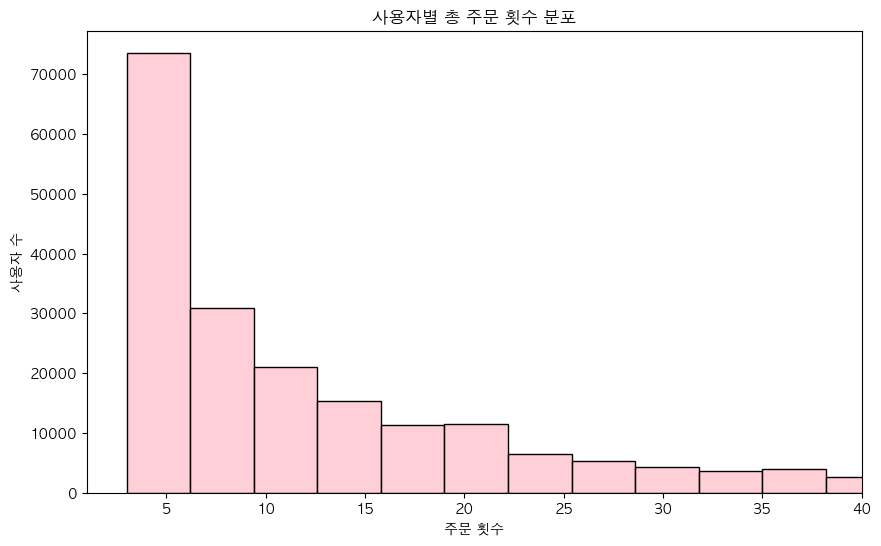

In [202]:

plt.figure(figsize=(10,6))
sns.histplot(user_order_counts, bins=30, kde=False, color = 'pink')
plt.title("사용자별 총 주문 횟수 분포")
plt.xlabel("주문 횟수")
plt.ylabel("사용자 수")
plt.xlim(1, 40)  # x축 범위 1~40으로 지정 ( 구매 없는 0 데이터는 없으므로 )
plt.show()

최소 주문 횟수가 3이라는 건, 데이터상에서 3번 이상 주문한 사용자만 포함된 거거나, 1~2번 주문한 사용자는 상대적으로 적거나 없다는 의미일 수 있음.

최대 주문 횟수가 99라서 정말 열심히 주문한 사용자도 있음을 알 수 있고,

평균 15는 보통 사용자들이 약 15회 정도 주문을 한다는 의미

그리고 주문 횟수가 많아질수록(즉, 충성도가 높아질수록) 해당 사용자 수는 점점 줄어듦

In [210]:
## (3) 요일별 주문 건수 시각화

#prior_df는 행 개수가 주문 건수가 아니라 구매 상품 개수이므로 'order_id' 기준으로 중복제거를 해주어야 함 !
# order_id는 하나의 주문 고유번호로,
# 하나의 주문은 반드시 한 시점에, 한 요일에만 발생한다
# 즉, order_id에 대응하는 order_dow는 항상 동일함.


prior_df.drop_duplicates('order_id').groupby('order_dow')['order_id'].count()
# 일요일, 월요일이 주문이 가장 많음

order_dow
0    557772
1    556705
2    441955
3    412400
4    401212
5    425982
6    418848
Name: order_id, dtype: int64

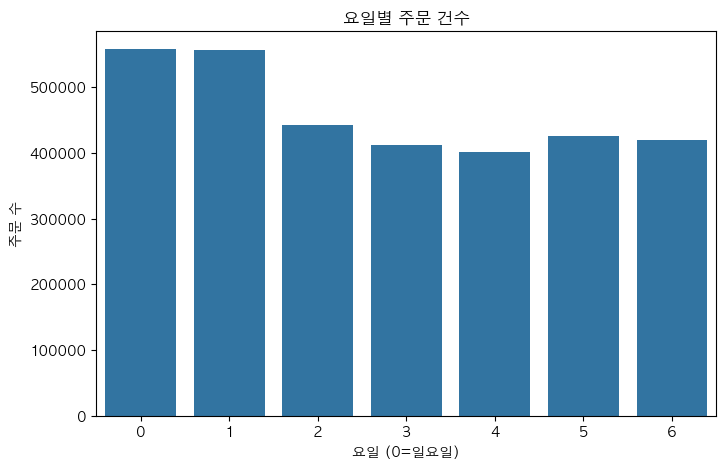

In [212]:
plt.figure(figsize=(8,5))
sns.countplot(x='order_dow', data=prior_df.drop_duplicates('order_id'))
plt.title("요일별 주문 건수")
plt.xlabel("요일 (0=일요일)")
plt.ylabel("주문 수")
plt.show()

일요일, 월요일에 주문 건수가 많다 !

In [229]:
# (4) 하루 중 언제 가장 많이 주문하는가?
order_by_hour = prior_df.drop_duplicates('order_id')
order_counts_by_hour = order_by_hour .groupby('order_hour_of_day')['order_id'].count()
order_counts_by_hour 

order_hour_of_day
0      21372
1      11596
2       7070
3       5120
4       5175
5       8972
6      28792
7      86656
8     168321
9     243496
10    271885
11    268006
12    256206
13    261174
14    265556
15    266132
16    255949
17    214080
18    170998
19    131620
20     98109
21     73436
22     57540
23     37613
Name: order_id, dtype: int64

/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1573/4041776415.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_counts_by_hour.index, y=order_counts_by_hour.values, palette='viridis')


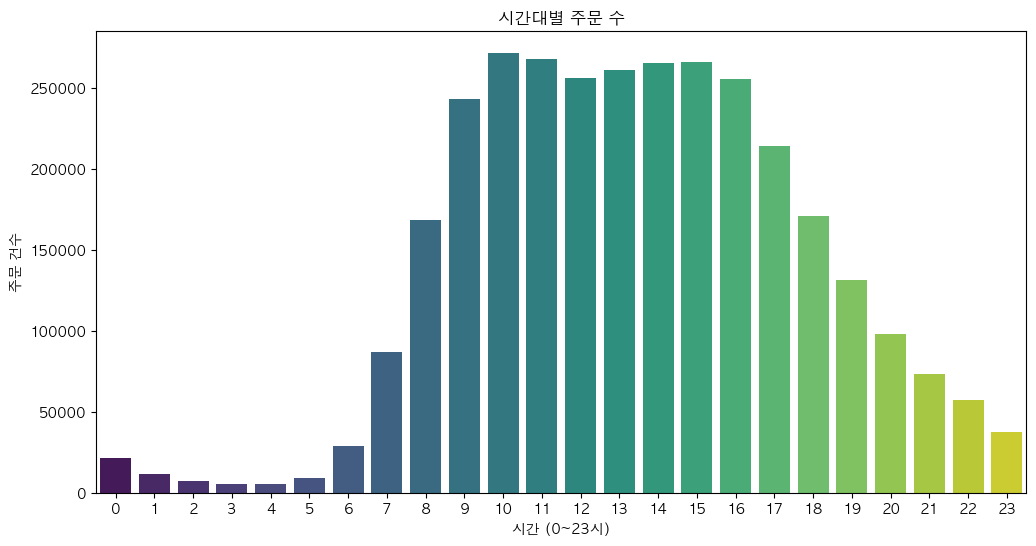

In [231]:
plt.figure(figsize=(12,6))
sns.barplot(x=order_counts_by_hour.index, y=order_counts_by_hour.values, palette='viridis')
plt.title("시간대별 주문 수")
plt.xlabel("시간 (0~23시)")
plt.ylabel("주문 건수")
plt.xticks(range(0,24))
plt.show()


피크타임 : 
👉 10시 ~ 16시 (낮, 오후 시간에 주문이 많다

In [250]:
# (5) 어느 상품이 가장 많이 판매되었는가?

product_counts = prior_df['product_name'].value_counts().reset_index()
product_counts.columns = ['상품명', '판매량']

# 상위 10개 상품 확인
top_products = product_counts.head(10)
top_products

,상품명,판매량
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


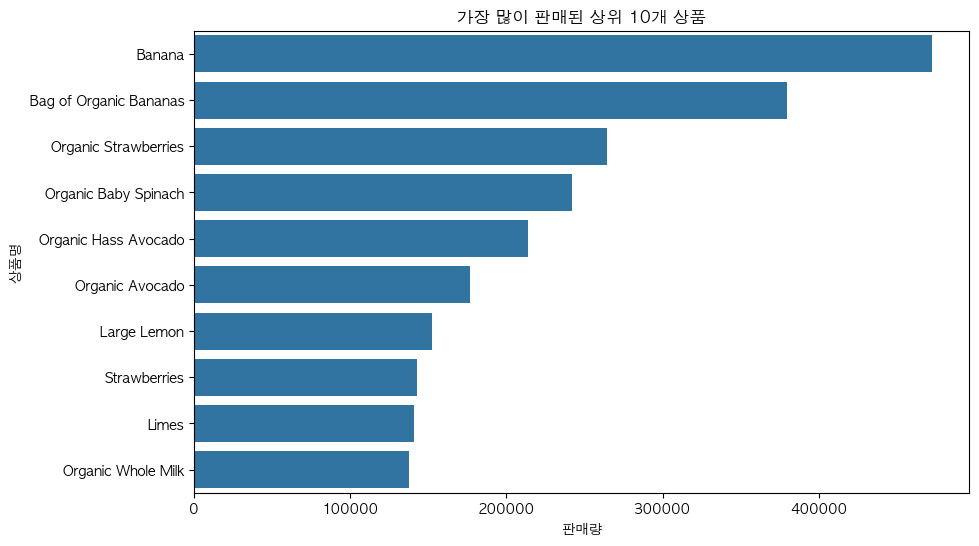

In [252]:
plt.figure(figsize=(10,6))
sns.barplot(x='판매량', y='상품명', data=top_products)
plt.title("가장 많이 판매된 상위 10개 상품")
plt.xlabel("판매량")
plt.ylabel("상품명")
plt.show()

가장 많이 팔린 상품은 Banana, Bag of Organic Bananas, Organic Strawberries ...

유기농 과일이 많이 팔리는 걸 보면, 건강한 식단을 중시하는 고객층이 많을 수도 있음.

In [106]:
# (6) 재구매율이 가장 높은 상품은 무엇인가??


# 상품별 재구매율 구하기 

reorder_ratio = prior_df.groupby('product_name')['reordered'].mean().reset_index()
reorder_ratio.columns = ['상품명', '재구매율']


# 어느 정도 팔린 상품만 필터링 (신뢰도 확보용, 선택사항)
# 재구매율이 높더라도 1~2번만 팔린 상품이면 신뢰도가 낮으니까, 50번 이상 팔린 상품만 고려하는 게 일반적

product_counts = prior_df['product_name'].value_counts().reset_index()
product_counts.columns = ['상품명', '판매량']
reorder_ratio = pd.merge(reorder_ratio, product_counts, on='상품명')
reorder_ratio


# 50번 이상 주문된 상품만 필터링
counts_50 = reorder_ratio[reorder_ratio['판매량'] >= 50]

# 재구매율 기준 정렬
top_reordered = counts_50.sort_values('재구매율', ascending=False).head(10)
top_reordered

,상품명,재구매율,판매량
37375,Raw Veggie Wrappers,0.941176,68
39866,Serenity Ultimate Extrema Overnight Pads,0.931034,87
8535,Chocolate Love Bar,0.920792,101
41798,Sparking Water,0.900000,60
24024,Maca Buttercups,0.900000,100
3831,Bars Peanut Butter,0.895522,67
41708,Soy Crisps Lightly Salted,0.893939,66
4255,Benchbreak Chardonnay,0.891892,111
29014,Organic Blueberry B Mega,0.885417,96
4176,Beer Can,0.884615,52


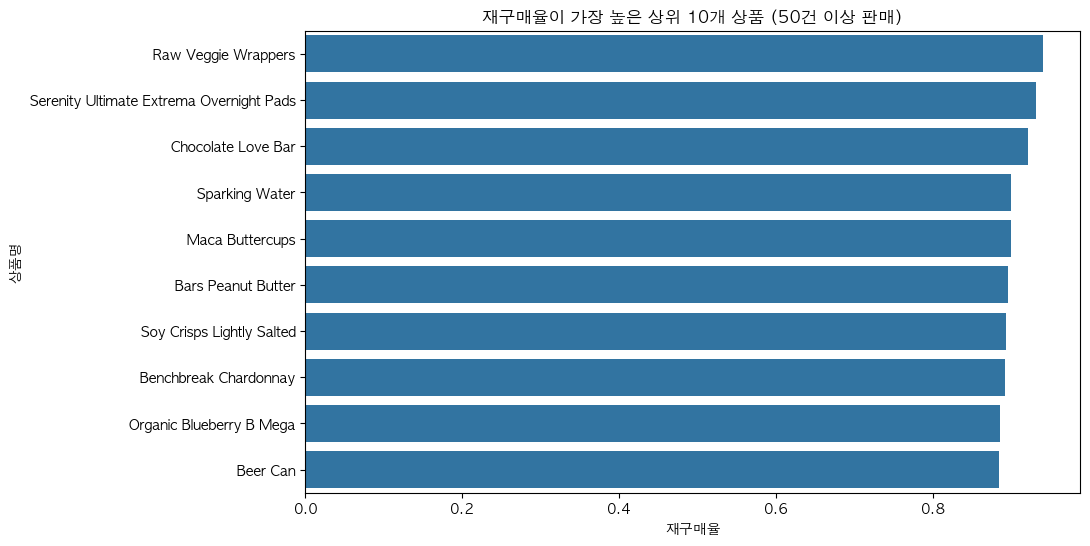

In [289]:
plt.figure(figsize=(10,6))
sns.barplot(x='재구매율', y='상품명', data=top_reordered)
plt.title("재구매율이 가장 높은 상위 10개 상품 (50건 이상 판매)")
plt.xlabel("재구매율")
plt.ylabel("상품명")
plt.show()

/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1573/996580822.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dept_reorder, x='department', y='reordered', palette='coolwarm')


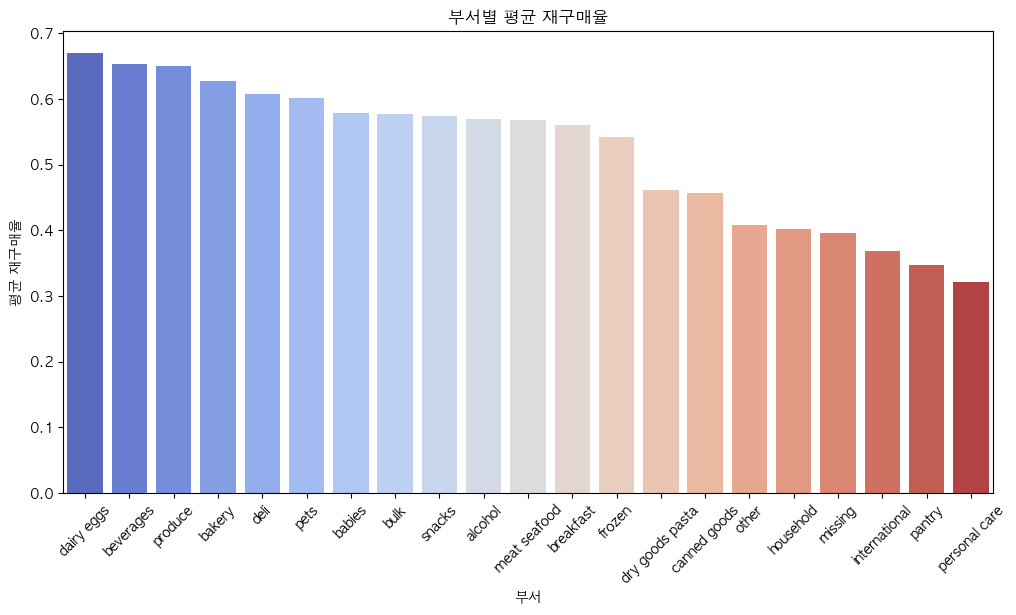

In [302]:
# (7) 부서별 평균 재구매율 계산

dept_reorder = prior_df.groupby('department')['reordered'].mean().reset_index()
dept_reorder = dept_reorder.sort_values('reordered', ascending=False)


plt.figure(figsize=(12,6))
sns.barplot(data=dept_reorder, x='department', y='reordered', palette='coolwarm')
plt.title('부서별 평균 재구매율')
plt.xlabel('부서')
plt.ylabel('평균 재구매율')
plt.xticks(rotation=45)
plt.show()


- 재구매율이 높은 부서들 :  유제품, 음료, 신선 농산물, 베이커리, 델리
일상적으로 자주 구매하고 꾸준히 재구매하는 제품들이 많다는 뜻! 

- 재구매율이 낮은 부서들 : 개인 위생용품, 상비 식품, 수입 식품, 생활용품 등
대체로 소모 속도가 느리거나, 특별한 경우에만 구매하는 상품들이 많다고 생각.

In [19]:
## (8) 고객별 상품 구매 패턴 파악하기

# 고객 한 명당 어떤 상품을 얼마나 자주 구매하는지 분석
# 재구매 성향이 강한 고객과 약한 고객 구분하기


# ((1)) 고객별 총 구매 상품 수 계산

total_orders_per_user = prior_df.groupby('user_id')['order_id'].count().reset_index()
total_orders_per_user.columns = ['user_id', 'total_orders']


# ((2)) 고객별 재구매 상품 수

reordered_per_user = prior_df[prior_df['reordered']==1].groupby('user_id')['order_id'].count().reset_index()
reordered_per_user.columns = ['user_id', 'reordered_count']

# 두 데이터 병합
user_reorder = pd.merge(total_orders_per_user, reordered_per_user, on='user_id', how='left')
user_reorder['reordered_count'] = user_reorder['reordered_count'].fillna(0)

# 고객별 재구매 비율 계산
user_reorder['reorder_ratio'] = user_reorder['reordered_count'] / user_reorder['total_orders']

# 결과 확인
user_reorder.head()

,user_id,total_orders,reordered_count,reorder_ratio
0,1,59,41.0,0.694915
1,2,195,93.0,0.476923
2,3,88,55.0,0.625000
3,4,18,1.0,0.055556
4,5,37,14.0,0.378378


In [21]:
# 1. 주문 단위로 '재구매가 포함됐는지 여부' 계산
order_reorder_flag = prior_df.groupby('order_id')['reordered'].max().reset_index()
# → 재구매 상품이 하나라도 있으면 reordered=1

# 2. 사용자별로 총 주문 수, 재구매 포함 주문 수 계산
orders_with_user = prior_df[['order_id', 'user_id']].drop_duplicates()
order_reorder_flag = order_reorder_flag.merge(orders_with_user, on='order_id', how='left')

# 3. 사용자별로 총 주문 수, 재구매 포함 주문 수 세기
user_total_orders = order_reorder_flag.groupby('user_id')['order_id'].count().reset_index()
user_total_orders.columns = ['user_id', 'total_orders']

user_reorder_orders = order_reorder_flag[order_reorder_flag['reordered'] == 1]
user_reorder_orders = user_reorder_orders.groupby('user_id')['order_id'].count().reset_index()
user_reorder_orders.columns = ['user_id', 'reordered_orders']

# 4. 병합하고 비율 계산
user_reorder_ratio = pd.merge(user_total_orders, user_reorder_orders, on='user_id', how='left')
user_reorder_ratio['reordered_orders'] = user_reorder_ratio['reordered_orders'].fillna(0)
user_reorder_ratio['reorder_ratio'] = user_reorder_ratio['reordered_orders'] / user_reorder_ratio['total_orders']

# 결과 확인
user_reorder_ratio.head()




# # 재구매율 분포 히스토그램
# plt.figure(figsize=(10,6))
# sns.histplot(user_reorder['reorder_ratio'], bins=30, kde=True, color='skyblue')
# plt.title('고객별 재구매율 분포')
# plt.xlabel('재구매율')
# plt.ylabel('고객 수')
# plt.show()

,user_id,total_orders,reordered_orders,reorder_ratio
0,1,10,9.0,0.900000
1,2,14,12.0,0.857143
2,3,12,11.0,0.916667
3,4,5,1.0,0.200000
4,5,4,3.0,0.750000


In [15]:
# 재구매율 기준으로 고객 그룹 나누기 (예: 0.6 이상 높은 그룹)

user_reorder['reorder_group'] = user_reorder['reorder_ratio'].apply(lambda x: '높음' if x >= 0.6 else '낮음')

# 재구매율 그룹별 고객 수 집계
group_counts = user_reorder['reorder_group'].value_counts()

# 파이차트 그리기
plt.figure(figsize=(6,6))
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'], startangle=90)
plt.title('재구매율 그룹별 고객 비율')
plt.show()

NameError: name 'user_reorder' is not defined

In [349]:
# (9) . 상품별 구매 빈도와 재구매율 분석

# 상품별 총 구매 횟수
product_counts = prior_df.groupby('product_name')['order_id'].count().reset_index()
product_counts.columns = ['product_name', 'total_purchases']

# 상품별 재구매율
product_reorder = prior_df.groupby('product_name')['reordered'].mean().reset_index()
product_reorder.columns = ['product_name', 'reorder_rate']

# 두 데이터 병합
product_stats = pd.merge(product_counts, product_reorder, on='product_name')

# 인기 상품 (판매량 기준 상위 20개)
top_products = product_stats.sort_values('total_purchases', ascending=False).head(20)

top_products


# # 시각화
# plt.figure(figsize=(12,6))
# sns.scatterplot(data=top_products, x='total_purchases', y='reorder_rate', hue='reorder_rate', size='total_purchases', palette='viridis', legend=False, sizes=(50, 300))
# plt.title('상위 20개 상품의 판매량과 재구매율')
# plt.xlabel('총 구매 횟수')
# plt.ylabel('재구매율')
# plt.show()

,product_name,total_purchases,reorder_rate
3676,Banana,472565,0.843501
3471,Bag of Organic Bananas,379450,0.832555
31920,Organic Strawberries,264683,0.777704
28840,Organic Baby Spinach,241921,0.772500
30297,Organic Hass Avocado,213584,0.796553
28804,Organic Avocado,176815,0.758103
22413,Large Lemon,152657,0.696038
42904,Strawberries,142951,0.698155
23420,Limes,140627,0.681007
32478,Organic Whole Milk,137905,0.830354


바나나, 유기농 바나나, 유기농 딸기 등 신선 과일류가
→ 판매량도 많고 재구매율도 0.7 이상으로 아주 높음
→ 충성 고객이 꾸준히 구매하는 인기 상품

In [367]:
## 문제 10. 카테고리(aisle)별 인기 상품 분석 및 추천 Top N 생성

aisle_product_counts = prior_df.groupby(['aisle', 'product_name'])['order_id'].count().reset_index()
aisle_product_counts.columns = ['aisle', 'product_name', 'purchase_count']

# 각 aisle 별로 판매량 상위 10개만 추출
top_products_per_aisle  = aisle_product_counts.groupby('aisle').apply( lambda x : x.sort_values('purchase_count', ascending = False).head(10)).reset_index(drop = True)
top_products_per_aisle.head(20)

/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1573/2718536083.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products_per_aisle  = aisle_product_counts.groupby('aisle').apply( lambda x : x.sort_values('purchase_count', ascending = False).head(10)).reset_index(drop = True)


,aisle,product_name,purchase_count
0,air fresheners candles,Original Scent Extra Strength Fabric Refresher...,588
1,air fresheners candles,Scented Soy Lavender Candle,501
2,air fresheners candles,Air Effects Linen & Sky Scent Air Freshener Spray,498
3,air fresheners candles,Air Effects Linen & Sky Air Refresher,492
4,air fresheners candles,Eucalyptus Essential Oil,418
5,air fresheners candles,Apple Cinnamon Scented Candles,378
6,air fresheners candles,Lavender Harvest Aromatherapy Mist,369
7,air fresheners candles,Clean Linen Air Freshener,337
8,air fresheners candles,100% Pure Lavender Oil,337
9,air fresheners candles,Clean Linen Jar Candle,325


In [370]:
# (11) 전체 인기 상품 Top N 추천 (전체 상품 기준)
# - 이 리스트는 주문 이력이 전혀 없는 신규 고객에게 기본 추천으로 쓸 수 있음 !

# 상품별 총 판매량 집계
popular_products = prior_df.groupby('product_name')['order_id'].count().reset_index()
popular_products.columns = ['product_name', 'purchase_count']

# 판매량 기준 내림차순 정렬 후 상위 20개 추출
top_20_popular_products = popular_products.sort_values('purchase_count', ascending=False).head(20)

print(top_20_popular_products)

                   product_name  purchase_count
3676                     Banana          472565
3471     Bag of Organic Bananas          379450
31920      Organic Strawberries          264683
28840      Organic Baby Spinach          241921
30297      Organic Hass Avocado          213584
28804           Organic Avocado          176815
22413               Large Lemon          152657
42904              Strawberries          142951
23420                     Limes          140627
32478        Organic Whole Milk          137905
31363       Organic Raspberries          137057
32565      Organic Yellow Onion          113426
30000            Organic Garlic          109778
32605          Organic Zucchini          104823
29008       Organic Blueberries          100060
11630            Cucumber Kirby           97315
29980        Organic Fuji Apple           89632
30577             Organic Lemon           87746
2628   Apple Honeycrisp Organic           85020
30139    Organic Grape Tomatoes         

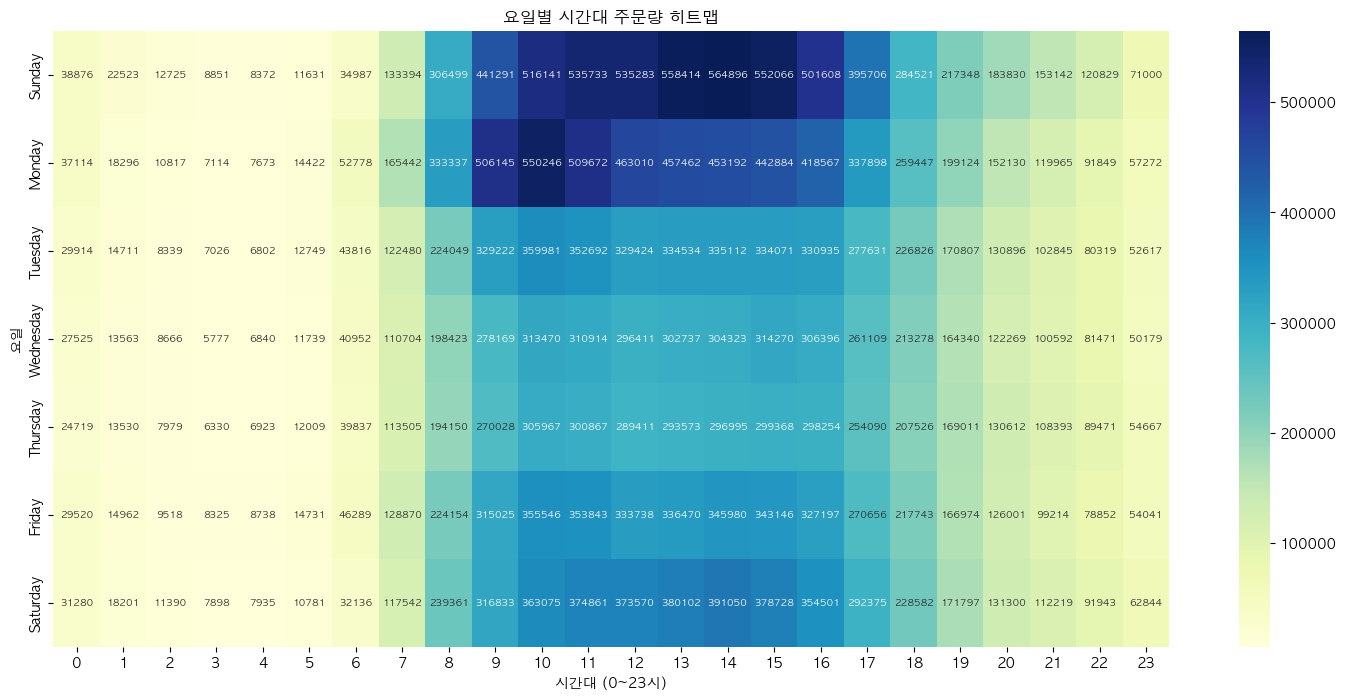

In [382]:
## 1. 요일 + 시간대별 주문량 Heatmap 만들기

df = prior_df.copy()

# 숫자 요일을 요일 이름으로 매핑
dow_map = {
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}
df['order_dow'] = df['order_dow'].map(dow_map)


heatmap_data_named = df.groupby(['order_dow', 'order_hour_of_day'])['order_id'].count().unstack()

# 요일 순서 정렬 (선택사항)
ordered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
heatmap_data_named = heatmap_data_named.reindex(ordered_days)

# 시각화
plt.figure(figsize=(18, 8))
sns.heatmap(
    heatmap_data_named,
    cmap='YlGnBu',
    annot=True,
    fmt='d',
    annot_kws={"size": 7}  # 숫자 크기 축소
)
plt.title('요일별 시간대 주문량 히트맵')
plt.xlabel('시간대 (0~23시)')
plt.ylabel('요일')
plt.show()

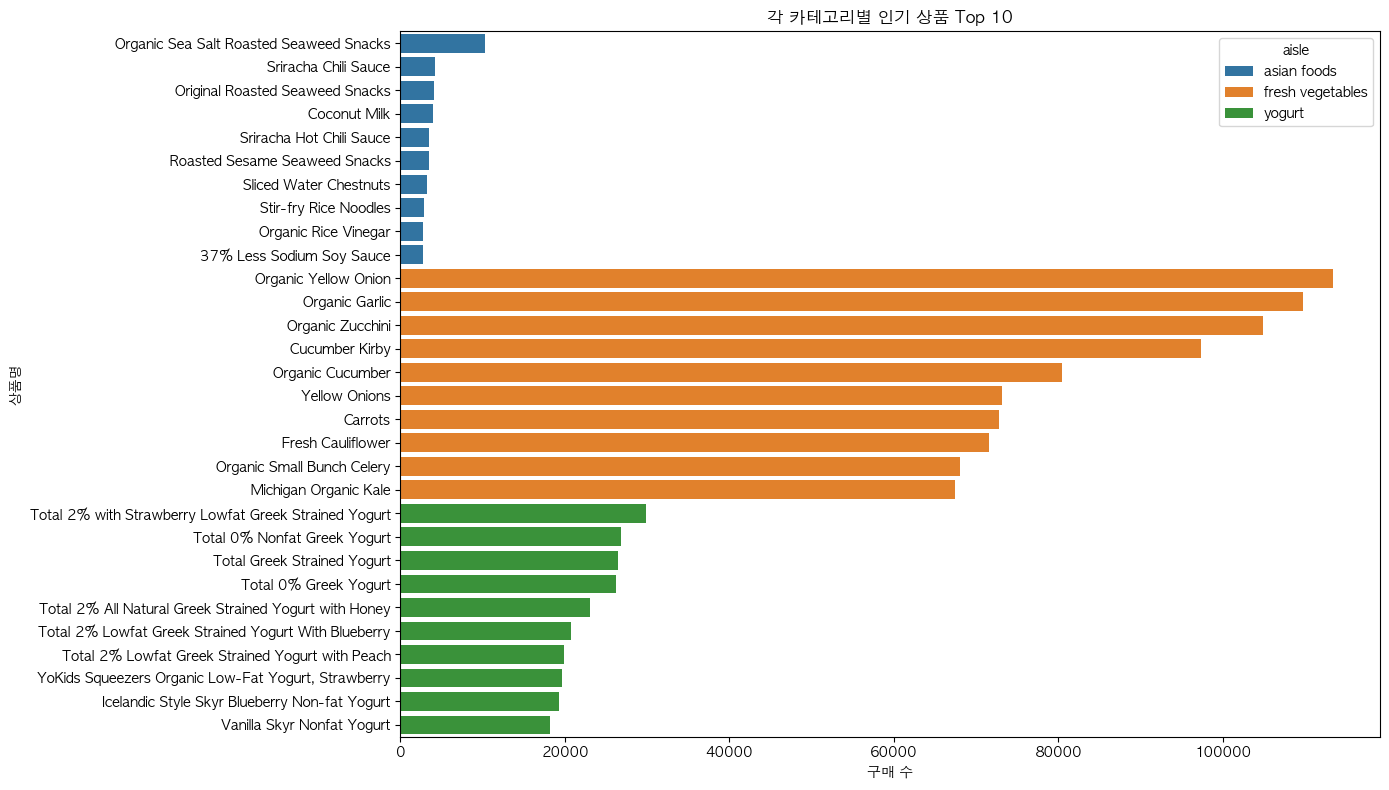

In [391]:
## 2. 특정 카테고리별 인기 상품 시각화 (feat.문제 10번)


# 예 )  ‘yogurt’, ‘fresh vegetables’만 추출해서 시각화해보기 !
target_aisles = ['yogurt', 'fresh vegetables', 'asian foods'] 

plot_df = top_products_per_aisle[top_products_per_aisle['aisle'].isin(target_aisles)]

plt.figure(figsize=(14,8))
sns.barplot(data=plot_df, x='purchase_count', y='product_name', hue='aisle', dodge=False)
plt.title("각 카테고리별 인기 상품 Top 10")
plt.xlabel("구매 수")
plt.ylabel("상품명")
plt.tight_layout()
plt.show()



In [111]:
## 3 .클러스터링으로 유사한 고객 그룹 나누기

# 고객별 총 주문 횟수
total_orders = prior_df.groupby('user_id')['order_id'].nunique()

# 고객별 총 구매 상품 수
total_products = prior_df.groupby('user_id')['product_id'].count()

# 고객별 재구매 횟수
reordered_counts = prior_df[prior_df['reordered']==1].groupby('user_id')['product_id'].count()

# 평균 주문 간격 (days_since_prior_order 평균)
avg_days_between_orders = prior_df.groupby('user_id')['days_since_prior_order'].mean()

# 데이터 합치기
user_summary = pd.DataFrame({
    'total_orders': total_orders,
    'total_products': total_products,
    'reordered_counts': reordered_counts,
    'avg_days_between_orders': avg_days_between_orders
}).fillna(0)

user_summary .head()

,total_orders,total_products,reordered_counts,avg_days_between_orders
user_id,,,,
1,10,59,41.0,18.542373
2,14,195,93.0,14.902564
3,12,88,55.0,10.181818
4,5,18,1.0,11.944444
5,4,37,14.0,10.189189


In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_summary)


scaled_df = pd.DataFrame(scaled_features, index=user_summary.index, columns=user_summary.columns)



# 클러스터 수는 우선 3개로 가정 !


kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(scaled_df)
user_summary['cluster'] = clusters
user_summary
# scaled_df.head()

,total_orders,total_products,reordered_counts,avg_days_between_orders,cluster
user_id,,,,,
1,10,59,41.0,18.542373,0
2,14,195,93.0,14.902564,0
3,12,88,55.0,10.181818,0
4,5,18,1.0,11.944444,0
5,4,37,14.0,10.189189,0
...,...,...,...,...,...
206205,3,32,8.0,9.687500,0
206206,67,285,135.0,3.985965,2
206207,16,223,131.0,13.278027,0


In [119]:

#  원래 df (prior_df 기반) 에 merge 하려면
df = prior_df.copy()

# user_id 기준으로 클러스터 정보 붙이기
df = df.merge(user_summary[['cluster']], left_on='user_id', right_index=True, how='left')

# df.head(


cluster_df = df.groupby('cluster').agg({
    'order_id': 'nunique',  # 주문 수
    'reordered': 'mean',    # 재구매율
    'product_id': 'count', # 총 구매량 등
    'days_since_prior_order' : 'mean'
}).round(2)

cluster_df.columns = ['주문수','재구매율','구매 수량','구매 간격']
cluster_df

,주문수,재구매율,구매 수량,구매 간격
cluster,,,,
0,1250068,0.41,11154901,14.79
1,677617,0.76,8744890,6.11
2,1287189,0.63,12534698,9.47


(3, 4)
4


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/var/folders/f4/1y5qvmvd5v514kbpgr0p58440000gn/T/ipykernel_1239/2976323731.py:41: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


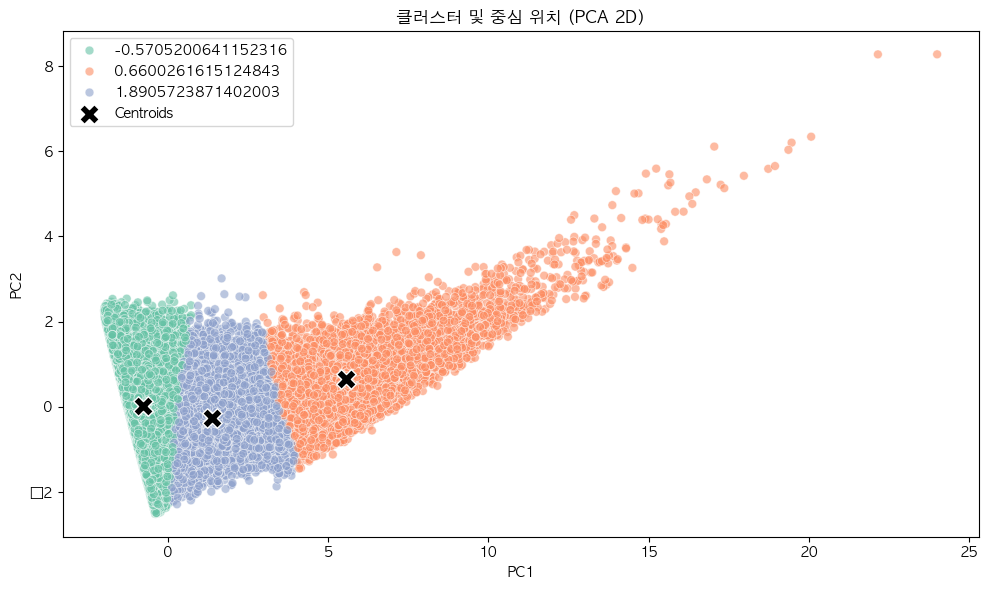

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA

# PCA 학습 및 변환 시 cluster 컬럼 제외하고 4개 피처만 사용
features_only = scaled_df.drop(columns=['cluster'])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_only)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=scaled_df.index)
pca_df['cluster'] = scaled_df['cluster'].values



print(kmeans.cluster_centers_.shape)
print(features_only.shape[1])

# # 유저 데이터 (2차원으로 축소된 상태라고 가정)
x = pca_df['PC1']
y = pca_df['PC2']
clusters = scaled_df['cluster']

# 클러스터 중심도 동일하게 PCA로 축소
cluster_centers_2d = pca.transform(kmeans.cluster_centers_)

# 산점도 그리기
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, hue=clusters, palette='Set2', alpha=0.6, s=40)

# 클러스터 중심 표시 (큰 점, 검은 테두리)
plt.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1],
            c='black', s=200, marker='X', label='Centroids', edgecolor='white')

plt.title('클러스터 및 중심 위치 (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.show()



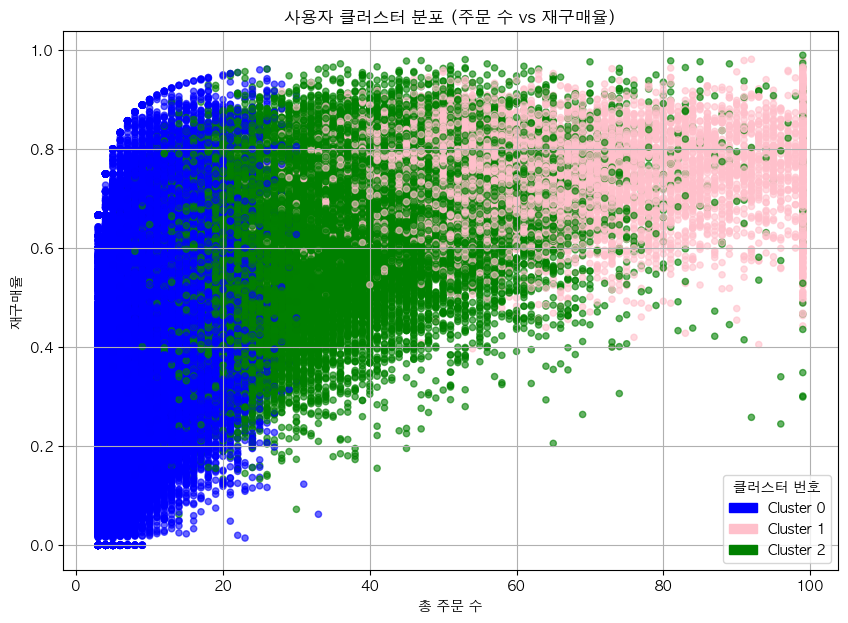

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# 클러스터별 색상 맵 생성
color_map = {0: 'blue', 1: 'pink', 2: 'green'}

# user_summary['cluster'] 값을 색상으로 매핑
colors = user_summary['cluster'].map(color_map)

plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    user_summary['주문수'],
    user_summary['재구매율'],
    c=colors,
    alpha=0.6,
    s=20
)

plt.xlabel('총 주문 수')
plt.ylabel('재구매율')
plt.title('사용자 클러스터 분포 (주문 수 vs 재구매율)')

# 범례를 직접 추가 (선택사항)
from matplotlib.patches import Patch
legend_elements = [
    Patch(color='blue', label='Cluster 0'),
    Patch(color='pink', label='Cluster 1'),
    Patch(color='green', label='Cluster 2')
]
plt.legend(handles=legend_elements, title='클러스터 번호')

plt.grid(True)
plt.show()


클러스터별 인기상품

모두 1,2순위가 banana, Bag of Organic Bananas임 -> 전체적으로 인기 많은 상품

구매 성향 차이를 뚜렷하게 구분하기 위해 Top-N 상품에서 공통 상품 제거 !

In [57]:
## banana, Bag of Organic Bananas를 제거한 후 다시 실행 !

# 제거할 상품 리스트
exclude_products = ['Banana', 'Bag of Organic Bananas']

# 클러스터별 Top N 상품 구하고, 제외
top_n = 10

filtered_top = (
    df[~df['product_name'].isin(exclude_products)]
    .groupby(['cluster', 'product_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['cluster', 'count'], ascending=[True, False])
    .groupby('cluster')
    .head(top_n)
)

filtered_top

### 시각화
# import seaborn as sns
# import matplotlib.pyplot as plt

# for cluster_id in sorted(filtered_top['cluster'].unique()):
#     cluster_data = filtered_top[filtered_top['cluster'] == cluster_id]
    
#     plt.figure(figsize=(10, 6))
#     sns.barplot(
#         data=cluster_data.sort_values('count', ascending=False),
#         x='count',
#         y='product_name',
#         palette='Set3'
#     )
#     plt.title(f'클러스터 {cluster_id} 인기 상품 (바나나 제외)')
#     plt.xlabel('구매 횟수')
#     plt.ylabel('상품명')
#     plt.tight_layout()
#     plt.show()


,cluster,product_name,count
27867,0,Organic Baby Spinach,48774
30859,0,Organic Strawberries,45270
27833,0,Organic Avocado,38559
29285,0,Organic Hass Avocado,36048
21639,0,Large Lemon,33553
41507,0,Strawberries,32918
22615,0,Limes,27552
31401,0,Organic Whole Milk,24750
30319,0,Organic Raspberries,23602
28029,0,Organic Blueberries,22815


모든 클러스터가 유기농 제품을 선호하는 경향이 매우 강하며,

클러스터 1, 3은 특히 **과일류(딸기, 라즈베리 등)**에 집중된 소비,

클러스터 0, 2는 채소(시금치, 아보카도) 중심으로 구성됨.

클러스터 3은 전반적으로 구매 빈도와 수량이 높아, 대가족 or 헬시푸드 마니아일 가능성이 있음.

In [34]:
# 다시... 더 다양한 피처를 가지고 도전해봐야 할 것 같아서
# 유저를 기준으로 특징 테이블 만들기 !


#### (1) 사용자별 각 aisle(카테고리)에서 차지하는 구매 비율
df = prior_df.copy()
user_aisle_cnt = df.groupby(['aisle','user_id'])['order_id'].count().reset_index()

user_total = df.groupby('user_id')['order_id'].count().reset_index()
user_total.columns = ['user_id', 'total_orders']

user_aisle_cnt = user_aisle_cnt.merge(user_total, on='user_id')
user_aisle_cnt['purchase_ratio'] = user_aisle_cnt['order_id'] / user_aisle_cnt['total_orders']
user_aisle_cnt

# user_id별로 각 aisle의 purchase_ratio를 한 개의 행으로 나타내는 피벗테이블 만들기
user_aisle_pivot = user_aisle_cnt.pivot(index = 'user_id', columns = 'aisle', values = 'purchase_ratio').fillna(0)

In [23]:
##### 유저 요약 통계 테이블 만들기 #####
user_summary = prior_df.groupby('user_id').agg(
    total_orders = ('order_id', 'nunique'),
    total_products = ('product_id', 'count'),
    reordered_counts = ('reordered', 'sum'),
    avg_days_between_orders = ('days_since_prior_order', 'mean')
).reset_index()

user_features = user_aisle_pivot.merge( user_summary, on='user_id')

user_features['reorder_ratio'] = user_features['reordered_counts'] / user_features['total_orders']
user_features

NameError: name 'user_aisle_pivot' is not defined

In [51]:
### user_features 데이터 저장하기 !!

### (3) Cold Start 대응 / (4) Matrix Factorization (with side info) 여기서 사용 !
user_features.to_csv("user_features.csv", index=False)

## (1) 고객-상품 매트릭스 기반 협업 필터링 적용 — 기본 흐름
1. 사용자-상품 행렬 준비 (우린 sparse_matrix 준비 완료)
user_id가 행(row), product_id가 열(column)인 희소행렬이 있어야 해

2. 유사도 계산
(1)사용자 기반 CF → 사용자 간 유사도 (코사인 유사도 많이 씀)  --> 데이터양이 너무 많아 비추천
대신 TruncatedSVD로 차원 축소한 후, KNN으로 Top-N 유사 유저 탐색 !!


(2) 상품 기반 CF → 상품 간 유사도 계산

3. 예측 점수 산출
유사한 사용자(또는 상품)를 기반으로 구매 가능성 예측

4. Top-N 추천 리스트 생성
예측 점수 높은 상품 순으로 고객에게 추천

In [5]:
import pandas as pd
import numpy as np
import os


# 경로 설정
base_path = '/Users/jeonseoyeong/Desktop/패스트캠퍼스 20기(파이썬)/팀플/'

# 변수명과 파일명 쌍 정의
file_list = {
    'aisles': 'aisles.csv',
    'order_products_prior': 'order_products__prior.csv',
    'order_products_train': 'order_products__train.csv',
    'orders': 'orders.csv',
    'products': 'products.csv',
    'departments': 'departments.csv'
}

# 반복문으로 개별 변수에 할당
for var_name, file_name in file_list.items():
    globals()[var_name] = pd.read_csv(os.path.join(base_path, file_name))


orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0).astype(float)


# (3) 데이터셋 병함
# prior 병합 (훈련용 데이터)
prior_orders = orders[orders['eval_set'] == 'prior']
prior = prior_orders.merge(order_products_prior, on='order_id')


#product_id로 products와 병합
prior = prior.merge(products, on='product_id')


# aisle_id로 aisles과 병합
prior = prior.merge(aisles, on='aisle_id')

# departments 와 병합

prior_df = prior.merge(departments, on='department_id')

In [7]:
# 세부주제별로 필요한 컬럼 뽑기

# (1) 고객-상품 매트릭스 및 협업 필터링용
cf_df = prior_df[['user_id', 'product_id', 'reordered','add_to_cart_order', 'order_number']]

# (2) 카테고리별 Top N 추천용
topn_df = prior_df[['product_id', 'product_id', 'aisle', 'department', 'reordered']]

# (3) Cold-start 대응용 (인기 상품 추천 or 콘텐츠 기반)
cold_start_df = prior_df[['product_id', 'product_id', 'aisle', 'department', 'reordered']]

# (4) 사용자 행동 기반 MF용
mf_df = prior_df[['user_id', 'product_id', 'reordered', 'add_to_cart_order', 'order_number']]

In [9]:
##### 1. 고객-상품 매트릭스 및 협업 필터링용


# (1)단계..
from scipy.sparse import csr_matrix

# 고객이 해당 상품을 몇 번 샀는지(또는 구매 여부)
purchase_counts =cf_df.groupby(['user_id','product_id']).size().reset_index(name='purchase_count')
# purchase_counts_pivot = purchase_counts.pivot(index='user_id', columns = 'product_name', values = 'purchase_count')

# purchase_counts_pivot

# user_id와 product_id를 인덱스로 매핑 (0부터 시작하는 정수)
user_id_map = {id:i for i, id in enumerate(purchase_counts['user_id'].unique())}
product_id_map = {id:i for i, id in enumerate(purchase_counts['product_id'].unique())}

purchase_counts['user_idx'] = purchase_counts['user_id'].map(user_id_map)
purchase_counts['product_idx'] = purchase_counts['product_id'].map(product_id_map)

# 희소 행렬 생성
sparse_matrix = csr_matrix((purchase_counts['purchase_count'], (purchase_counts['user_idx'], purchase_counts['product_idx'])))

print(sparse_matrix.shape)  # (사용자수, 상품수)

(206209, 49677)


In [11]:
# 2. 상품 간 유사도 계산

from sklearn.metrics.pairwise import cosine_similarity


# 상품 x 사용자 행렬로 전치
product_user_matrix = sparse_matrix.T

# 상품 간 코사인 유사도 계산 ( 두 상품간의 유사도 (0~1) 의미 )
product_similarity = cosine_similarity(product_user_matrix, dense_output=False)

print("product_user_matrix shape:", product_user_matrix.shape)
print("product_similarity type:", type(product_similarity))
print("product_similarity shape:", product_similarity .shape)

product_user_matrix shape: (49677, 206209)
product_similarity type: <class 'scipy.sparse._csr.csr_matrix'>
product_similarity shape: (49677, 49677)


In [13]:
# 3. 예측 점수 산출 / 4. Top-N 추천 리스트 생성

# Step 1: 특정 상품 기준으로 유사한 상품 Top-N 찾기

#특정 상품 하나 선택
product_id = 12432

product_idx = product_id_map[product_id]

#해당 상품의 유사도 벡터 뽑기
similarities  = product_similarity[product_idx] 

# 희소 행렬을 밀집 벡터로 바꾸기 (다루기 쉽게)
similarities_dense = similarities.toarray().flatten()

top_indices = np.argsort(similarities_dense)[::-1]  # 내림차순 정렬 인덱스
top_indices = top_indices[similarities_dense[top_indices] < 0.99999]  # 자기 자신 제외
top_n_indices = top_indices[:10]  

# (4) 인덱스를 product_id로 매핑 (역맵핑 딕셔너리 필요)
inv_product_id_map = {v: k for k, v in product_id_map.items()}
top_n_product_ids = [inv_product_id_map[i] for i in top_n_indices]

print("추천 상품 ID 리스트:", top_n_product_ids)


product_id_to_name = dict(zip(products['product_id'], products['product_name']))

# top_n_product_ids 리스트를 상품 이름으로 변환
top_n_product_names = [product_id_to_name[pid] for pid in top_n_product_ids]

print("추천 상품 이름 리스트:", top_n_product_names)


추천 상품 ID 리스트: [18951, 15954, 15339, 21825, 25625, 32498, 14942, 16066, 38432, 27099]
추천 상품 이름 리스트: ['Fresh Cut Chopped Spinach', 'Frozen Concentrated Orange Juice', 'Fuzzy Navel Cooler', 'Infusions Strawberry Basil Flavor Enhancer', 'Nonfat Yogurt', 'Lemon Pepper Fish Complete Meals', 'Apple Butter', 'Unsalted Tops Saltine Crackers', 'Green Goddess Dressing', 'Peanuts, Caramel and Chewy Nougat Chocolate Candy Bar']


AttributeError: 'dict' object has no attribute 'head'